Original Data (first 5 rows):
   Feature1  Feature2
0 -0.361035 -0.499299
1 -1.322430  0.200600
2  0.319851  0.085714
3 -1.751356 -0.983921
4  0.135297  0.677857

Original Data Description:
         Feature1    Feature2
count  104.000000  104.000000
mean     0.156798    0.122205
std      1.283360    1.236919
min     -4.000000   -6.000000
25%     -0.574554   -0.553954
50%      0.088743    0.200745
75%      0.707570    0.715441
max      7.000000    5.000000

Mean Vector:
[0.15679848 0.12220456]

Covariance Matrix:
[[1.64701398 0.23040619]
 [0.23040619 1.52996748]]

Inverse Covariance Matrix:
[[ 0.62022587 -0.09340322]
 [-0.09340322  0.66767477]]

Data with Mahalanobis Distances (first 5 rows):
   Feature1  Feature2  Mahalanobis_Distance
0 -0.361035 -0.499299              0.603402
1 -1.322430  0.200600              1.175965
2  0.319851  0.085714              0.135978
3 -1.751356 -0.983921              1.637345
4  0.135297  0.677857              0.456796

Chi-Squared Threshold (alpha=0.01,

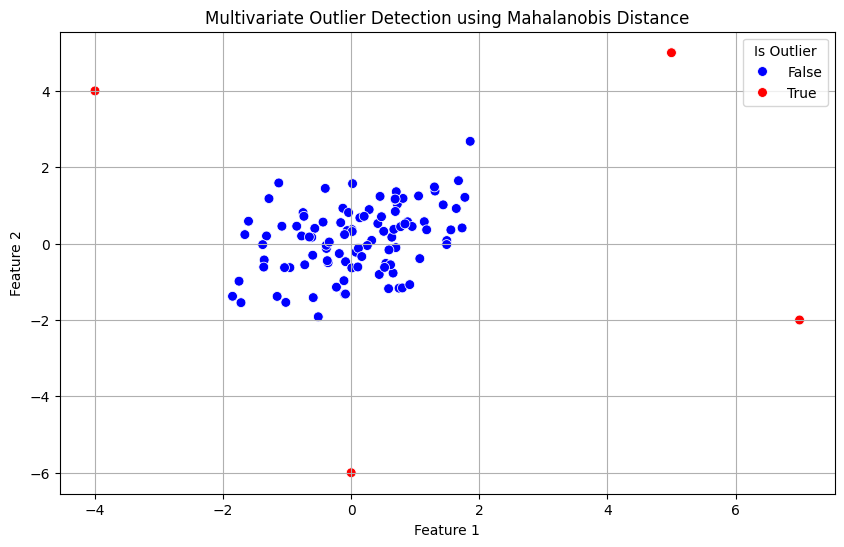

In [1]:
# Question: Multivariate Outlier Detection Using Mahalanobis Distance
# Description: Implement Mahalanobis distance to detect multivariate outliers in a dataset.

# Import necessary libraries
import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
import matplotlib.pyplot as plt
import seaborn as sns

# --- Create a sample multivariate dataset ---
# Let's create a dataset with two features and introduce a few potential outliers.
# We'll make the features somewhat correlated to demonstrate how Mahalanobis distance
# accounts for the relationship between variables.
np.random.seed(42) # Setting a seed for reproducibility of the random data

# Generate some correlated data points using a multivariate normal distribution
mean = [0, 0] # Mean vector for the distribution
cov = [[1, 0.5], [0.5, 1]] # Covariance matrix showing a positive correlation (0.5) between features
data = np.random.multivariate_normal(mean, cov, 100) # Generate 100 data points

# Introduce some artificial outliers to the dataset
outliers = np.array([[5, 5], [-4, 4], [0, -6], [7, -2]]) # Define outlier points
data = np.vstack([data, outliers]) # Stack the outliers onto the generated data

# Create a Pandas DataFrame from the data for easier manipulation and visualization
df = pd.DataFrame(data, columns=['Feature1', 'Feature2'])

print("Original Data (first 5 rows):")
print(df.head())
print("\nOriginal Data Description:")
# Display summary statistics for the original data
print(df.describe())

# --- Calculate Mahalanobis Distance ---

# 1. Calculate the mean vector of the dataset
mean_vector = df.mean().values
print("\nMean Vector:")
print(mean_vector)

# 2. Calculate the covariance matrix of the dataset
# The covariance matrix captures the variance of each feature and the covariance between pairs of features.
cov_matrix = df.cov().values
print("\nCovariance Matrix:")
print(cov_matrix)

# 3. Calculate the inverse of the covariance matrix
# The inverse covariance matrix is crucial for the Mahalanobis distance calculation.
# Use a try-except block to handle potential singularity issues (if the matrix is not invertible,
# which can happen with highly correlated or linearly dependent features).
try:
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    print("\nInverse Covariance Matrix:")
    print(inv_cov_matrix)

    # 4. Calculate Mahalanobis distance for each data point
    mahalanobis_distances = []
    for index, row in df.iterrows():
        # The mahalanobis function from scipy.spatial.distance calculates the distance
        # between a point (row.values) and the mean (mean_vector) using the inverse covariance matrix (inv_cov_matrix).
        distance = mahalanobis(row.values, mean_vector, inv_cov_matrix)
        mahalanobis_distances.append(distance)

    # Add the calculated Mahalanobis distances as a new column to the DataFrame
    df['Mahalanobis_Distance'] = mahalanobis_distances

    print("\nData with Mahalanobis Distances (first 5 rows):")
    print(df.head())

    # --- Set a threshold for outlier detection ---
    # A statistically common approach is to use the chi-squared distribution.
    # For a p-dimensional dataset (p features), the squared Mahalanobis distance (D_M^2)
    # follows a chi-squared distribution with p degrees of freedom, assuming the data is multivariate normal.
    # We'll use a significance level (alpha) to find the threshold.
    alpha = 0.01 # Significance level (e.g., 1%). A smaller alpha means a stricter threshold.
    degrees_of_freedom = df.shape[1] # The number of features in the dataset
    # The threshold is the value from the chi-squared distribution such that the probability
    # of a value being less than or equal to the threshold is (1 - alpha).
    # chi2.ppf is the percent point function (inverse of the CDF).
    threshold = chi2.ppf(1 - alpha, degrees_of_freedom)
    print(f"\nChi-Squared Threshold (alpha={alpha}, df={degrees_of_freedom}): {threshold:.4f}")

    # Identify outliers based on the threshold
    # Points where the squared Mahalanobis distance is greater than the threshold are considered potential outliers.
    # Note: scipy's mahalanobis function returns the distance (D_M), not the squared distance (D_M^2).
    # So we compare the squared distance (distance**2) with the threshold.
    df['Is_Outlier'] = (df['Mahalanobis_Distance']**2 > threshold)

    print("\nData with Outlier Identification (first 5 rows):")
    print(df.head())

    print("\nIdentified Outliers:")
    # Filter the DataFrame to show only the rows identified as outliers
    outliers_df = df[df['Is_Outlier']]
    print(outliers_df)

    # --- Visualize the data and outliers ---
    # Create a scatter plot to visualize the data points and highlight the identified outliers.
    plt.figure(figsize=(10, 6)) # Set the figure size
    # Use seaborn's scatterplot, mapping 'Feature1' to x, 'Feature2' to y, and 'Is_Outlier' to color (hue).
    # Use different colors ('blue' for non-outliers, 'red' for outliers) and set point size (s).
    sns.scatterplot(x='Feature1', y='Feature2', hue='Is_Outlier', data=df, palette={False: 'blue', True: 'red'}, s=50)
    plt.title('Multivariate Outlier Detection using Mahalanobis Distance')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(title='Is Outlier') # Add a legend to distinguish outliers
    plt.grid(True) # Add a grid for better readability
    plt.show() # Display the plot

except np.linalg.LinAlgError:
    # This block is executed if the inverse of the covariance matrix cannot be calculated.
    print("\nError: The covariance matrix is singular (not invertible).")
    print("This can happen if you have perfectly correlated features or fewer samples than features.")
    print("Consider removing highly correlated features or using a different method.")

